In [1]:
# Library includes
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import random

import requests
import zipfile
from pathlib import Path
import tqdm

# Helper functions

from model_functions import *

from visualize_results import *

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Multi-Model Comparison Variable
models_and_results = []

In [3]:
# Examine 
def walk_through_dir(dir_path):
    print("in walk through dir")
    """Walks through dir_path, returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

data_path = Path("../data")
image_path = data_path / "CATANIST V2/"
walk_through_dir(image_path)

in walk through dir
There are 2 directories and 1 images in ../data/CATANIST V2
There are 11 directories and 1 images in ../data/CATANIST V2/test
There are 0 directories and 11 images in ../data/CATANIST V2/test/eight
There are 0 directories and 11 images in ../data/CATANIST V2/test/eleven
There are 0 directories and 11 images in ../data/CATANIST V2/test/nine
There are 0 directories and 11 images in ../data/CATANIST V2/test/three
There are 0 directories and 11 images in ../data/CATANIST V2/test/ten
There are 0 directories and 6 images in ../data/CATANIST V2/test/twelve
There are 0 directories and 6 images in ../data/CATANIST V2/test/two
There are 0 directories and 11 images in ../data/CATANIST V2/test/six
There are 0 directories and 4 images in ../data/CATANIST V2/test/desert
There are 0 directories and 11 images in ../data/CATANIST V2/test/five
There are 0 directories and 11 images in ../data/CATANIST V2/test/four
There are 11 directories and 1 images in ../data/CATANIST V2/train
Ther

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('../data/CATANIST V2/train'), PosixPath('../data/CATANIST V2/test'))

In [22]:
from torchvision.transforms import v2, transforms

train_data_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.Grayscale(num_output_channels=3),
    v2.RandomAffine(degrees=180,translate=(0.2, 0.2),interpolation=transforms.InterpolationMode.BILINEAR),
    # v2.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 2))], p=.8),
    # Turn the image into a torch tensor
    v2.ToTensor(),
])

test_data_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.Grayscale(num_output_channels=3),
    # v2.RandomApply([transforms.GaussianBlur(kernel_size=17, sigma=(0.5, 2))], p=.8),
    # Turn the image into a torch tensor
    v2.ToTensor(),
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform,
                                 target_transform=None)
class_names = train_data.classes

len(train_data), len(test_data)

(970, 93)

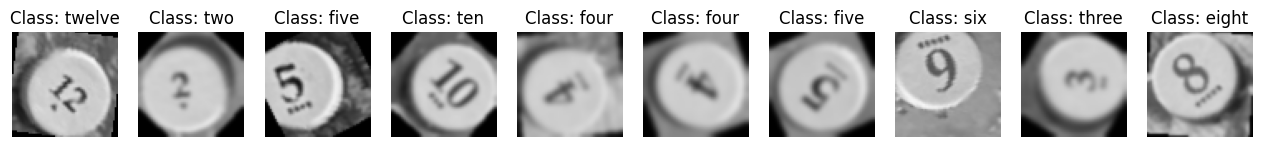

In [7]:
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=10,
                      display_shape=False)

In [8]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16d68e5d0>,
 <torch.utils.data.dataloader.DataLoader at 0x16d692910>)

In [9]:
device = ("cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
device

'mps'

# ResNet Model

In [10]:
class BasicBlock(nn.Module):
    def __init__(self, input_shape: int, output_shape:int, stride=1) -> None:
        super(BasicBlock, self).__init__()
        # Conv layer 1
        self.conv1 = nn.Conv2d(input_shape, 
                               output_shape, 
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        # Batch norm 1
        self.bn1 = nn.BatchNorm2d(output_shape)
        # Activation
        self.relu = nn.ReLU(inplace=True)
        
        # Conv layer 2
        self.conv2 = nn.Conv2d(output_shape, 
                               output_shape,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        # Batch norm 2
        self.bn2 = nn.BatchNorm2d(output_shape)
        
        # Account for differences in stride length if not 1 & num filters
        self.downsample = nn.Sequential()
        if stride != 1 or input_shape != output_shape:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_shape, output_shape,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(output_shape)
            )
    def forward(self, x):
        identity = x
        logits = self.conv1(x)
        logits = self.bn1(logits)
        logits = self.relu(logits)
        logits = self.conv2(logits)
        logits = self.bn2(logits)
        logits += self.downsample(identity)
        logits = self.relu(logits)
        return logits

In [11]:
class ResNet(nn.Module):
    def __init__(self, input_shape, block, layers, class_cnt):
        super(ResNet, self).__init__()
        self.num_classes = class_cnt
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=input_shape, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Create 3 'blocks'
        self.block1 = self.make_layer(block, 64, layers[0], stride=1)
        self.block2 = self.make_layer(block, 128, layers[1], stride=2)
        self.block3 = self.make_layer(block, 256, layers[2], stride=2)
        # Average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        self.fc = nn.Linear(256, class_cnt)
    def make_layer(self, block, output_shape, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, output_shape, stride))
        self.in_channels = output_shape
        for _ in range(1, blocks):
            layers.append(block(output_shape, output_shape, stride=1))
        return nn.Sequential(*layers)
    def forward(self, x):
        logits = self.conv1(x)
        # print(f"x shape after conv block 1: {x.shape}")
        logits = self.bn1(logits)
        # print(f"x shape after batch norm 1: {x.shape}")
        logits = self.relu(logits)
        logits = self.block1(logits)
        # print(f"x shape after res block 1: {x.shape}")
        logits = self.block2(logits)
        # print(f"x shape after res block 2: {x.shape}")
        logits = self.block3(logits)
        # print(f"x shape after res block 3: {x.shape}")
        logits = self.avg_pool(logits)
        logits = logits.view(logits.size(0), -1)
        logits = self.fc(logits)
        return logits

In [12]:
model = ResNet(input_shape=3, 
               block=BasicBlock,
               layers=[2, 2, 2],
               class_cnt=len(class_names)).to(device)

## Test Image

In [13]:
# Get a single image batch
image_batch, label_batch = next(iter(test_dataloader))
image_batch.shape, label_batch.shape
model(image_batch.to(device))

tensor([[-4.8341e-01,  5.8339e-01, -5.1486e-01,  9.1058e-01, -2.4897e-01,
          3.7032e-03,  2.0204e-01, -6.3209e-01, -5.5503e-01,  1.1480e+00,
         -2.5328e-01],
        [-5.1705e-01,  6.1410e-01, -6.5787e-01,  9.2193e-01, -4.0721e-01,
          1.2371e-01,  1.6598e-01, -8.0900e-01, -5.4629e-01,  1.3284e+00,
         -2.1113e-01],
        [-5.2810e-01,  5.6924e-01, -5.0017e-01,  8.3928e-01, -2.2123e-01,
          3.3111e-02,  1.2587e-01, -6.2099e-01, -4.1288e-01,  1.0919e+00,
         -1.9607e-01],
        [-4.7114e-01,  4.5870e-01, -5.2848e-01,  8.6832e-01, -3.0786e-01,
          6.3477e-03, -4.6644e-02, -7.5175e-01, -3.5088e-01,  1.2611e+00,
          1.5263e-02],
        [-4.8787e-01,  4.9166e-01, -5.6152e-01,  7.7549e-01, -2.9027e-01,
          9.0475e-03,  3.6700e-02, -6.9136e-01, -4.2053e-01,  1.2311e+00,
         -9.1320e-02],
        [-6.0161e-01,  9.4986e-01, -7.1845e-01,  1.1813e+00, -4.5871e-01,
          1.6625e-01,  8.6548e-03, -1.4833e+00, -6.9820e-01,  1.7321e+0

In [23]:
# Model variables
INPUT_SHAPE = 3
OUTPUT_SHAPE = len(class_names)
# Hyperparameters (Batch size is in cell 10)
EPOCHS = 25
LEARNING_RATE = 0.001
LOSS_FN = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

hyperparameters = {"Model Name": "ResNet","Epochs":EPOCHS, "Batch Size": BATCH_SIZE, "Learning Rate":LEARNING_RATE, "Loss Function": LOSS_FN, "Optimizer": optimizer}
hyperparameters

{'Model Name': 'ResNet',
 'Epochs': 25,
 'Batch Size': 32,
 'Learning Rate': 0.001,
 'Loss Function': CrossEntropyLoss(),
 'Optimizer': torch.optim.adam.Adam}

In [24]:
### Train ResNet
model_resnet = ResNet(input_shape=INPUT_SHAPE, 
                    block=BasicBlock,
                    layers=[2, 2, 2],
                    class_cnt=OUTPUT_SHAPE).to(device)

resnet_optimizer = optimizer(model_resnet.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train simple model
model_resnet_results = train(model=model_resnet,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=resnet_optimizer,
                            loss_fn=LOSS_FN,
                            epochs=EPOCHS,
                            device=device)

# End the timer
end_time = timer()
print(f"ResNet training time: {end_time-start_time:.3f} seconds")

# Record results into a list of tuples where each tuple has the hyperparameter dictionary as well as the results
models_and_results.append([hyperparameters, model_resnet_results])

  4%|▍         | 1/25 [00:04<01:59,  4.96s/it]

Epoch: 1 | train_loss: 1.8508 | train_acc: 0.3458 | test_loss: 5.9727 | test_acc: 0.1002


  8%|▊         | 2/25 [00:09<01:51,  4.83s/it]

Epoch: 2 | train_loss: 1.3807 | train_acc: 0.5032 | test_loss: 12.7928 | test_acc: 0.1469


 12%|█▏        | 3/25 [00:14<01:46,  4.83s/it]

Epoch: 3 | train_loss: 1.1299 | train_acc: 0.6248 | test_loss: 3.5163 | test_acc: 0.1451


 16%|█▌        | 4/25 [00:19<01:41,  4.81s/it]

Epoch: 4 | train_loss: 0.9253 | train_acc: 0.7089 | test_loss: 14.6016 | test_acc: 0.1659


 20%|██        | 5/25 [00:23<01:35,  4.76s/it]

Epoch: 5 | train_loss: 0.7272 | train_acc: 0.7946 | test_loss: 8.2710 | test_acc: 0.1243


 24%|██▍       | 6/25 [00:29<01:34,  4.97s/it]

Epoch: 6 | train_loss: 0.6284 | train_acc: 0.8171 | test_loss: 7.3377 | test_acc: 0.1868


 28%|██▊       | 7/25 [00:34<01:29,  4.98s/it]

Epoch: 7 | train_loss: 0.4733 | train_acc: 0.8708 | test_loss: 9.0761 | test_acc: 0.1868


 32%|███▏      | 8/25 [00:39<01:25,  5.02s/it]

Epoch: 8 | train_loss: 0.3100 | train_acc: 0.9331 | test_loss: 10.1568 | test_acc: 0.2805


 36%|███▌      | 9/25 [00:44<01:20,  5.01s/it]

Epoch: 9 | train_loss: 0.3560 | train_acc: 0.8950 | test_loss: 4.2756 | test_acc: 0.4368


 40%|████      | 10/25 [00:49<01:14,  4.98s/it]

Epoch: 10 | train_loss: 0.2415 | train_acc: 0.9506 | test_loss: 3.2270 | test_acc: 0.3534


 44%|████▍     | 11/25 [00:54<01:09,  4.96s/it]

Epoch: 11 | train_loss: 0.1972 | train_acc: 0.9554 | test_loss: 1.0649 | test_acc: 0.7015


 48%|████▊     | 12/25 [00:59<01:04,  4.93s/it]

Epoch: 12 | train_loss: 0.1972 | train_acc: 0.9506 | test_loss: 52.9750 | test_acc: 0.0679


 52%|█████▏    | 13/25 [01:04<01:00,  5.02s/it]

Epoch: 13 | train_loss: 0.2271 | train_acc: 0.9385 | test_loss: 0.7325 | test_acc: 0.7425


 56%|█████▌    | 14/25 [01:09<00:54,  4.96s/it]

Epoch: 14 | train_loss: 0.3050 | train_acc: 0.9141 | test_loss: 1.2942 | test_acc: 0.6577


 60%|██████    | 15/25 [01:14<00:49,  4.93s/it]

Epoch: 15 | train_loss: 0.1502 | train_acc: 0.9738 | test_loss: 3.7345 | test_acc: 0.3118


 64%|██████▍   | 16/25 [01:19<00:44,  4.93s/it]

Epoch: 16 | train_loss: 0.1279 | train_acc: 0.9677 | test_loss: 2.7102 | test_acc: 0.5305


 68%|██████▊   | 17/25 [01:23<00:39,  4.92s/it]

Epoch: 17 | train_loss: 0.0766 | train_acc: 0.9829 | test_loss: 2.4710 | test_acc: 0.4680


 72%|███████▏  | 18/25 [01:28<00:34,  4.93s/it]

Epoch: 18 | train_loss: 0.0750 | train_acc: 0.9788 | test_loss: 1.0186 | test_acc: 0.6203


 76%|███████▌  | 19/25 [01:33<00:29,  4.92s/it]

Epoch: 19 | train_loss: 0.0765 | train_acc: 0.9806 | test_loss: 2.6261 | test_acc: 0.3671


 80%|████████  | 20/25 [01:38<00:24,  4.91s/it]

Epoch: 20 | train_loss: 0.0684 | train_acc: 0.9929 | test_loss: 6.3142 | test_acc: 0.2493


 84%|████████▍ | 21/25 [01:43<00:19,  4.92s/it]

Epoch: 21 | train_loss: 0.1224 | train_acc: 0.9655 | test_loss: 5.2061 | test_acc: 0.3473


 88%|████████▊ | 22/25 [01:48<00:14,  4.99s/it]

Epoch: 22 | train_loss: 0.1697 | train_acc: 0.9490 | test_loss: 7.5428 | test_acc: 0.2909


 92%|█████████▏| 23/25 [01:53<00:10,  5.04s/it]

Epoch: 23 | train_loss: 0.1467 | train_acc: 0.9556 | test_loss: 1.4437 | test_acc: 0.6203


 96%|█████████▌| 24/25 [01:59<00:05,  5.06s/it]

Epoch: 24 | train_loss: 0.0617 | train_acc: 0.9909 | test_loss: 0.1465 | test_acc: 0.9562


100%|██████████| 25/25 [02:04<00:00,  4.96s/it]

Epoch: 25 | train_loss: 0.0370 | train_acc: 0.9940 | test_loss: 0.0878 | test_acc: 0.9885
ResNet training time: 124.099 seconds


## Results after 25 epochs and normal transform on both test and train data:
- Epoch: 25 | train_loss: 0.0370 | train_acc: 0.9940 | test_loss: 0.0878 | test_acc: 0.9885

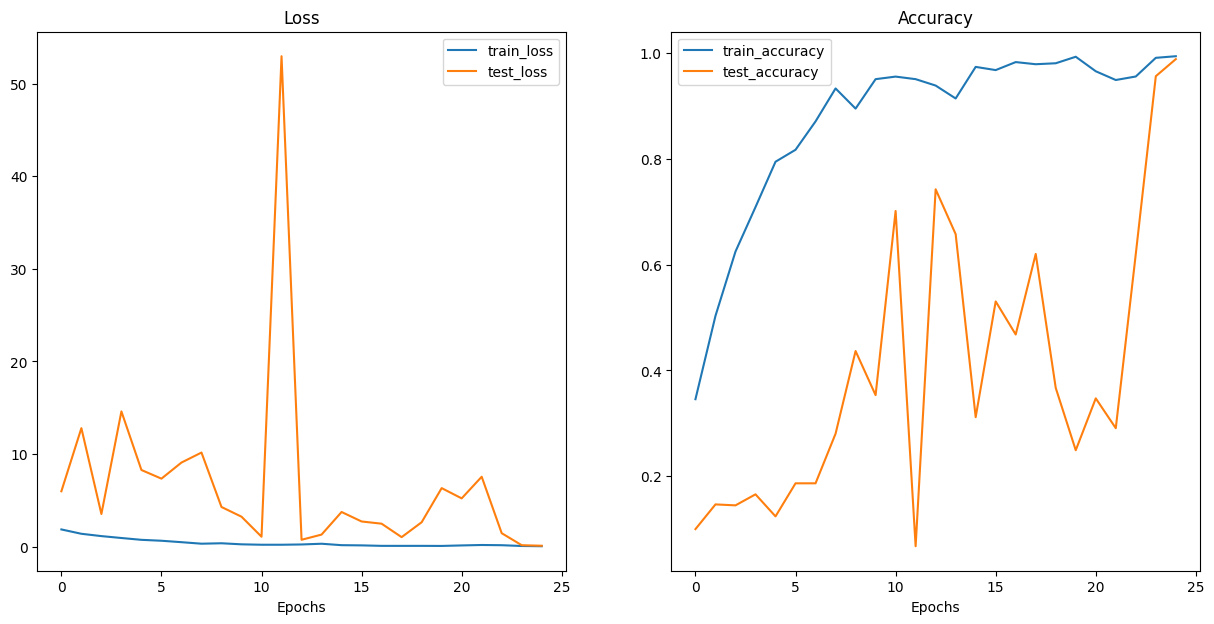

In [25]:
plot_loss_curves(model_resnet_results)

## Test on a custom image

In [28]:
custom_image_path = "../data/CATANIST V2/test/desert/066.jpg"

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image /= 255

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.Grayscale(num_output_channels=3)
])

custom_image_transformed = custom_image_transform(custom_image[:3, :, :])

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 60, 60])
New shape: torch.Size([3, 64, 64])


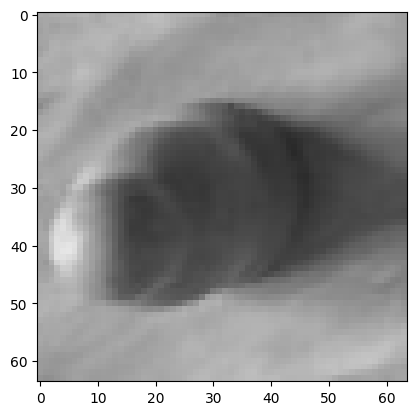

In [29]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [30]:
model_resnet.eval()
with torch.inference_mode():
    custom_image_pred = model_resnet(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction class: {class_names[custom_image_pred_label]}")

Prediction class: desert


## Save the model

In [26]:
from pathlib import Path 

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create the model save path
MODEL_NAME = "catanistv2_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_resnet.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/catanistv2_1.pth
